# Infer ***cytosol*** - part 3️⃣
(🚨🚨🚨🚨 Steps 4-9 depend on establishing a good solution here.)

--------------

## OBJECTIVE:  Infer sub-cellular component #3: ***cytosol***  in order to understand interactome 

To measure shape, position, and size of the cytosol of the cell body -- the cytosol minus the nucleus.    

Dependencies:
The ***cytoso*** inference rely on the ***nuclei*** AND ***cytosol*** inference.  Therefore all of the sub-cellular objects rely on this segmentation.





# IMPORTS

In [1]:
# top level imports
from pathlib import Path
import os, sys
from collections import defaultdict

import numpy as np

from skimage.morphology import binary_erosion
# # package for io 
from aicsimageio import AICSImage

import napari

### import local python functions in ../infer_subc_2d
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))

from infer_subc_2d.utils.file_io import (read_czi_image,
                                                                    list_image_files)
from infer_subc_2d.utils.img import *

from infer_subc_2d.constants import (TEST_IMG_N,
                                                                    NUC_CH ,
                                                                    LYSO_CH ,
                                                                    MITO_CH ,
                                                                    GOLGI_CH ,
                                                                    PEROXI_CH ,
                                                                    ER_CH ,
                                                                    LIPID_CH ,
                                                                    RESIDUAL_CH )          

from infer_subc_2d.organelles import infer_soma, fixed_infer_soma, fixed_infer_nuclei, find_optimal_Z

%load_ext autoreload
%autoreload 2

test_img_n = 5

------------------------
# LOAD RAW IMAGE DATA
Identify path to _raw_ image data and load our example image


In [2]:
# build the datapath
# all the imaging data goes here.
data_root_path = Path(os.path.expanduser("~")) / "Projects/Imaging/data"

# linearly unmixed ".czi" files are here
data_path = data_root_path / "raw"
im_type = ".czi"

# get the list of all files
img_file_list = list_image_files(data_path,im_type)
test_img_name = img_file_list[test_img_n]


In [3]:

img_data,meta_dict = read_czi_image(test_img_name)

# get some top-level info about the RAW data
channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']


/opt/anaconda3/envs/napariNEW/lib/python3.9/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


In [4]:
# make sure we have removed Z
if len(scale)>2:
    scale = scale[1:]

## Now get the single "optimal" slice of all our organelle channels and infer the SOMA

takes ~ 4 seconds to calculate

In [5]:
ch_to_agg = ( LYSO_CH ,
                        MITO_CH ,
                        GOLGI_CH ,
                        PEROXI_CH ,
                        ER_CH ,
                        LIPID_CH )
                            
nuc_ch = NUC_CH
optimal_Z = find_optimal_Z(img_data, nuc_ch, ch_to_agg) 


In [6]:

# img_2D = img_data[:,[optimal_Z],:,:].copy()
img_2D = select_z_from_raw(img_data, optimal_Z)

soma_mask =  fixed_infer_soma(img_2D) 


## get the inferred nuclei object

(takes < 1 sec)

In [7]:
nuclei_object =  fixed_infer_nuclei(img_2D, soma_mask) 


# IMAGE PROCESSING Objective 3:  infer ***cytosol***

## summary of steps

➡️ INPUT
- labeled ***nuclei*** (objective #1)
- labeled ***soma*** (objective #2)

PRE-PROCESSING
- erode ***nuclei*** (shrink)

CORE PROCESSING
  - XOR(***nuclei***, ***soma***)

- POST-PROCESSING
  - N/A

OUTPUT ➡️ 
- mask of ***cytosol***
- ***cytosol*** object (intensity)


## PRE-PROCESSING

In [8]:
###################
# PRE_PROCESSING
###################

#nuclei_eroded1 = morphology.binary_erosion(nuclei_object,  footprint=morphology.ball(3) )
nuclei_eroded = binary_erosion(nuclei_object)  



## CORE PROCESSING

In [9]:

###################
# CORE_PROCESSING
###################


cyto_object = np.logical_and(soma_mask,~nuclei_eroded)

cyto_object_xor = np.logical_xor(soma_mask,nuclei_eroded)

#cyto_object = binary_dilation(cyto_object)

In [10]:


viewer = napari.view_image( #viewer.add_image(
    cyto_object,
    scale=scale,
    opacity=0.3,
)    

viewer.add_image(
    nuclei_eroded,
    scale=scale,
    opacity=0.3,
)    

viewer.add_image(
    nuclei_object,
    scale=scale,
    opacity=0.3,
)    


<Image layer 'nuclei_object' at 0x16a31e460>

# DEFINE `_infer_cytosol` function

Based on the _prototyping_ above define the function to infer cytosol.  


In [11]:
# copy this to base.py for easy import

def _infer_cytosol(soma_mask, nuclei_object, erode_nuclei = True):
    """
    Procedure to infer cytosol from linearly unmixed input.

    Parameters
    ------------
    nuclei_object: np.ndarray
        a 3d image containing the nuclei signal

    soma_mask: np.ndarray
        a 3d image containing the soma signal

    erode_nuclei: bool
        should we erode?

    Returns
    -------------
    cytosol_mask: np.ndarray (bool)
      
    """


    if erode_nuclei:
        # cytosol_mask = np.logical_and(soma_mask, ~binary_erosion(nuclei_object))
        cytosol_mask = np.logical_xor(soma_mask, binary_erosion(nuclei_object))
    else:
        # cytosol_mask = np.logical_and(soma_mask, ~nuclei_object)
        cytosol_mask = np.logical_xor(soma_mask, nuclei_object)


    return cytosol_mask


--------------------------

# TEST `infer_cytosol` exported functions


##
`infer_cytosol` procedure

In [12]:
from infer_subc_2d.organelles.cytosol import infer_cytosol

_cytosol_mask =  _infer_cytosol(soma_mask, nuclei_object) 

cytosol_mask =  infer_cytosol(soma_mask, nuclei_object) 


In [13]:


viewer.scale_bar.visible = True
viewer.add_image(
    cytosol_mask,
    scale=scale 
)

viewer.add_labels(
    _cytosol_mask,
    scale=scale 
)

viewer.add_labels(
    nuclei_object,
    scale=scale 
)

viewer.add_image(
    nuclei_eroded,
    scale=scale 
)

<Image layer 'nuclei_eroded [1]' at 0x17f73ed90>

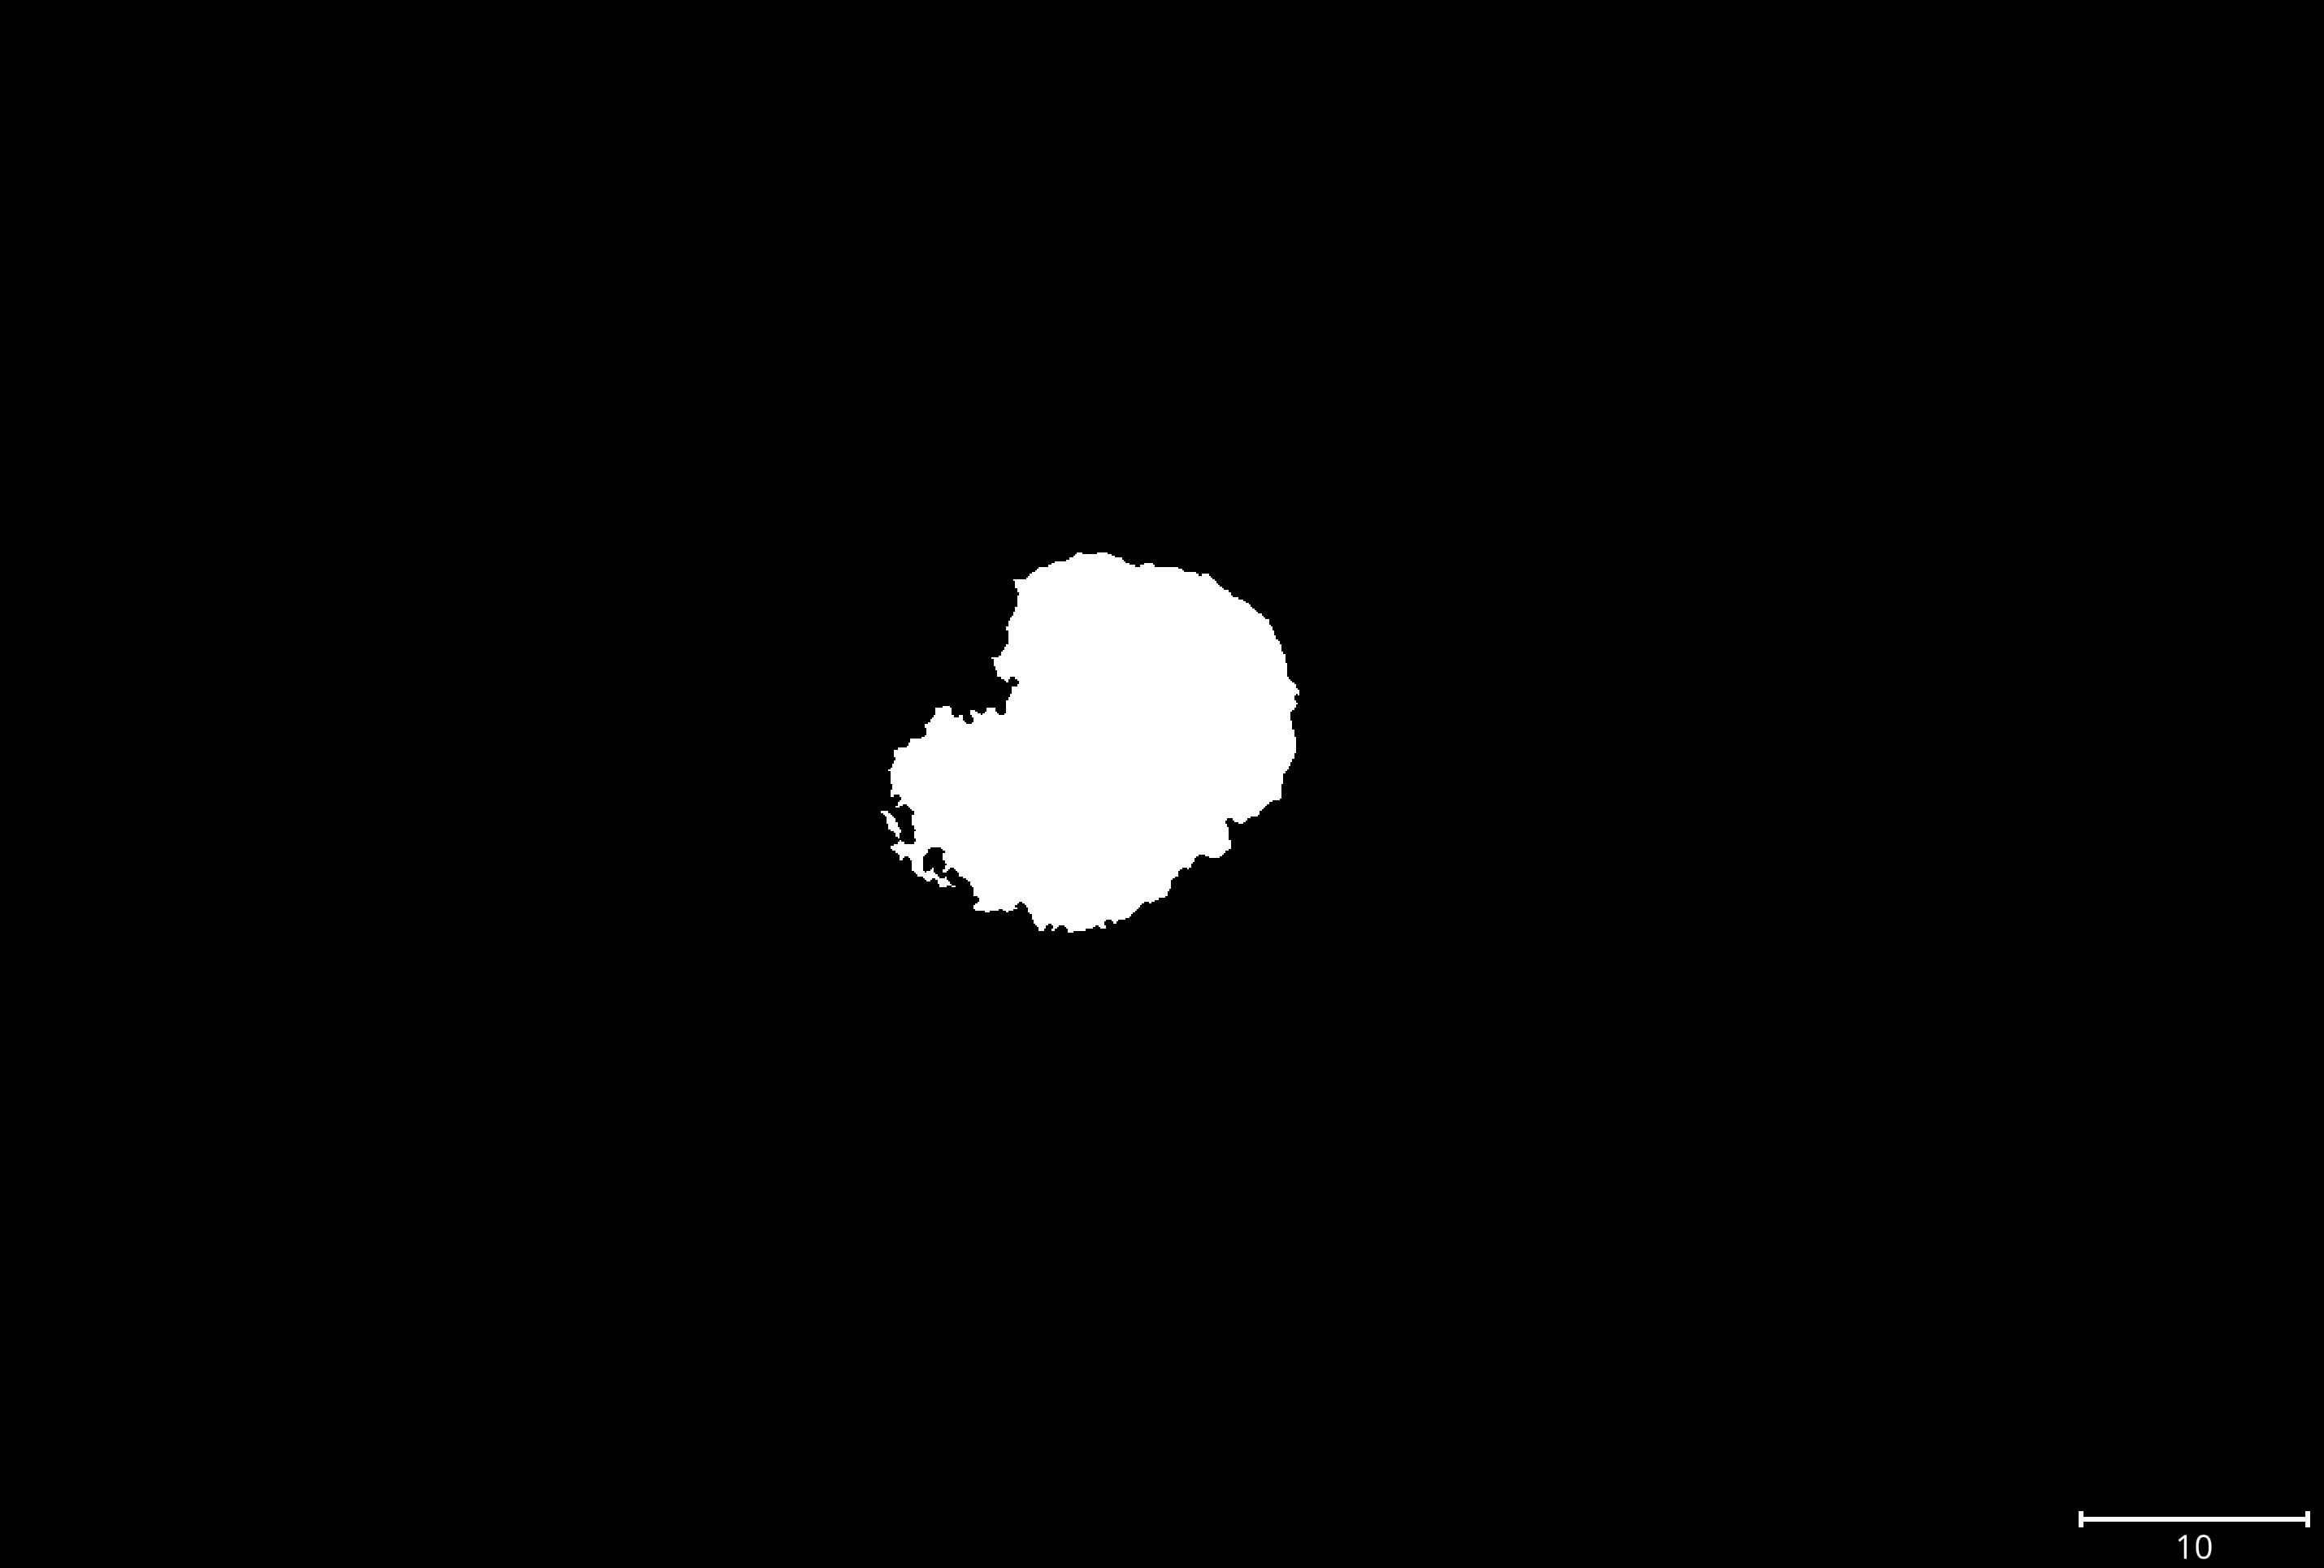

In [14]:
from napari.utils.notebook_display import nbscreenshot

# viewer.dims.ndisplay = 3
# viewer.camera.angles = (-30, 25, 120)
nbscreenshot(viewer, canvas_only=True)

--------------------------
## Write workflow .json
Now that we've added our function specs we can compose workflows.

In [15]:
def make_infer_cytosol_dict():
    """
    Procedure to infer infer from linearly unmixed input. (logical soma AND NOT nucleus)

    Parameters
    ------------
    nuclei_object: np.ndarray
        a 3d image containing the nuclei object

    soma_mask: np.ndarray
        a 3d image containing the soma object (mask)

    erode_nuclei: bool
        should we erode?

    Returns
    -------------
    cytosol_mask: np.ndarray (bool)

    """
    step_name = []
    function_name = []
    category =[]
    parameter_values = []
    parent = []
   
    ###################
    # EXTRACT
    ###################   

    step_name.append("1")
    function_name.append("fixed_get_optimal_Z_img")
    category.append("extraction")
    parameter_values.append(None)
    parent.append(0)


    step_name.append("2")
    function_name.append("fixed_infer_soma")
    category.append("extraction")
    parameter_values.append( None )
    parent.append(1)

    step_name.append("3")
    function_name.append("fixed_infer_nuclei")
    category.append("extraction")
    parameter_values.append( None )
    parent.append([1,2])

    step_name.append("4")
    function_name.append("infer_cytosol")
    category.append("postprocessing")
    parameter_values.append(dict(erode_nuclei = True ))
    parent.append([2,3])

    out_dict = dict()
    for i,stepn in enumerate(step_name):
        entry = dict(category=category[i],
                            function=function_name[i],
                            parameter_values=parameter_values[i],
                            parent=parent[i]
        )
        if entry['parameter_values'] is None:
            _ = entry.pop('parameter_values')
        out_dict[stepn] = entry
        
    return out_dict

In [16]:
from infer_subc_2d.organelles_config.helper import write_workflow_json

infer_cytosol_dict = make_infer_cytosol_dict()

write_workflow_json("conf_1.3.cytosol_from_raw", infer_cytosol_dict)

PosixPath('/Users/ahenrie/Projects/Imaging/infer-subc-2D/infer_subc_2d/organelles_config/conf_1.3.cytosol_from_raw.json')

## make function json to add to `all_functions.json`
### infer_nuclei 

In [17]:
from infer_subc_2d.organelles_config.helper import add_function_spec_to_widget_json

_infer_cytosol=  {
        "name": "infer infer_cytosol",
        "python::module": "infer_subc_2d.organelles",
        "python::function": "infer_cytosol",
        "parameters": {
                "erode_nuclei" : {
                        "widget_type": "drop-down",
                        "data_type": "bool",
                        "options": [
                        True,
                        False
                        ]
            }
        }
}

add_function_spec_to_widget_json("infer_cytosol",_infer_cytosol, overwrite=True)

function infer_cytosol is already in all_functions.json
overwriting  infer_cytosol


1

In [22]:
viewer.close()

: 